# **Image Compression with Diffusion Generative Model**

---



---



Diffusion Generative Model (DGM) : DGMs have been applied to image compression in several ways.
One approach is to use the lower-dimensional representation learned by the DGM as a compact representation of the image, and then use lossy compression techniques, such as quantization, to further reduce the size of the representation. Another approach is to use the DGM to generate an approximation of the original image, which can then be compressed using standard image compression algorithms, such as JPEG or PNG.

### Hence implementing the second approach:
To use the DGM to generate an approximation of the original image, which can then be compressed using standard image compression algorithms, such as JPEG or PNG.

In [ ]:
from google.colab import files
from IPython.display import Image


In [ ]:
upload = files.upload()

Saving DIFFU MODEL.png to DIFFU MODEL.png


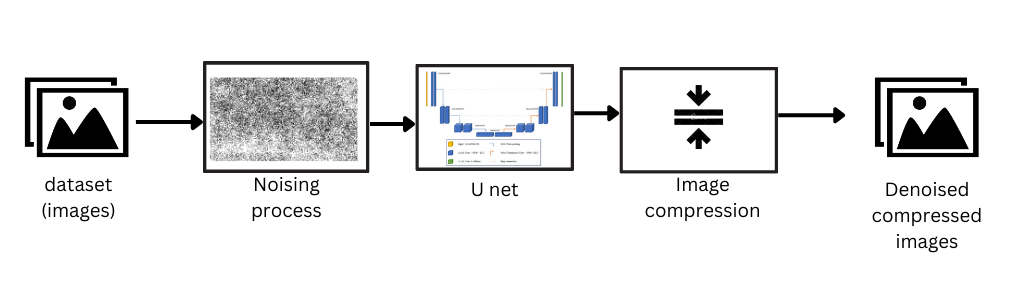

In [ ]:
Image('diff.png')

# Implementation


In [ ]:
# @title Install requirements
!pip install datasets &>> install.log

In [ ]:
#@title imports and utility functions
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np


def img_to_tensor(im):
  return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

def gather(consts: torch.Tensor, t: torch.Tensor):
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

## 2.1 Dataset

We'll start with a classic small dataset, with 32px square images from 10 classes. For convenience we just pull a version that is avalable on the huggingface hub.

  0%|          | 0/2 [00:00<?, ?it/s]

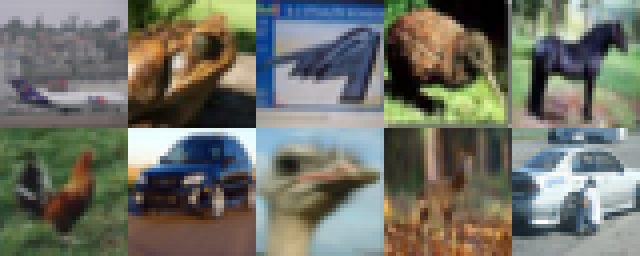

In [ ]:
#@title cifar10 - 32px images in 10 classes
cifar10 = load_dataset('cifar10')

# View
image = Image.new('RGB', size=(32*5, 32*2))
for i in range(10):
  im = cifar10['train'][i]['img']
  image.paste(im, ( (i%5)*32, (i//5)*32 ))
image.resize((32*5*4, 32*2*4), Image.NEAREST)

# To train our model at different time steps adding noise

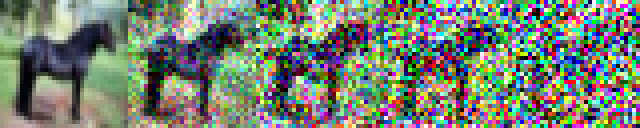

In [ ]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):
  mean = gather(alpha_bar, t) ** 0.5 * x0 # now alpha_bar
  var = 1-gather(alpha_bar, t) # (1-alpha_bar)
  eps = torch.randn_like(x0)
  return mean + (var ** 0.5) * eps

# Show im at different stages
ims = []
start_im = cifar10['train'][4]['img']
x0 = img_to_tensor(start_im).squeeze()
for t in [0, 20, 40, 60, 80]:
  x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long))
  ims.append(tensor_to_image(x))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

we can now calculate xt without having to do `for t in range...`.

## 2.3 UNETs


In [ ]:
#@title Unet Definition

import math
from typing import Optional, Tuple, Union, List
import torch
from torch import nn

# activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# The time embedding
class TimeEmbedding(nn.Module):
    def __init__(self, n_channels: int): #n_channels` is the number of dimensions in the embedding
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)
        return emb

# Residual blocks include 'skip' connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(t)[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.act2(self.norm2(h)))

        # Add the shortcut connection and return
        return h + self.shortcut(x)

class AttentionBlock(nn.Module):
    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=1)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)
        return res


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x

class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module): #Scale up the feature map by 2 \times
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

# The core class definition (aka the important bit)
class UNet(nn.Module):

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):

        super().__init__()
        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

Dummy data (testing)

In [ ]:
# A dummy batch of 10 3-channel 32px images
x = torch.randn(10, 3, 32, 32)

# 't' - what timestep are we on
t = torch.tensor([50.], dtype=torch.long)

# Define the unet model
unet = UNet()

# The foreward pass (takes both x and t)
model_output = unet(x, t)

# The output shape matches the input.
model_output.shape

<ipython-input-67-8092a4f90080>:5: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  t = torch.tensor([50.], dtype=torch.long)


torch.Size([10, 3, 32, 32])

## 2.4 Training Time

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

Why not predict the denoised image directly? Mostly just due to convenience - the noise is nicely scaled with a mean of zero, and this well-suited to being modeled with a neural network. we can make it easy by tweaking our `q_xt_x0` function to return both the noised image ($x_t$) and the noise itself, which will be the 'target' our network tries to produce.


In [ ]:
# Create the model
unet = UNet(n_channels=32).cuda()

# Set up some parameters
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Modified to return the noise itself as well
def q_xt_x0(x0, t):
  mean = gather(alpha_bar, t) ** 0.5 * x0
  var = 1-gather(alpha_bar, t)
  eps = torch.randn_like(x0).to(x0.device)
  return mean + (var ** 0.5) * eps, eps # also returns noise

# Training params
batch_size = 128 # Lower this if hitting memory issues
lr = 2e-4 # Explore this - might want it lower when training on the full dataset

losses = [] # Store losses for later plotting

dataset = cifar10['train']#.select(range(10000)) # to use a 10k subset for demo

optim = torch.optim.AdamW(unet.parameters(), lr=lr) # Optimizer

for i in tqdm(range(0, len(dataset)-batch_size, batch_size)): # Run through the dataset
  ims = [dataset[idx]['img'] for idx in range(i,i+batch_size)] # Fetch some images
  tims = [img_to_tensor(im).cuda() for im in ims] # Convert to tensors
  x0 = torch.cat(tims) # Combine into a batch
  t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long).cuda() # Random 't's
  xt, noise = q_xt_x0(x0, t) # Get the noised images (xt) and the noise (our target)
  pred_noise = unet(xt.float(), t) # Run xt through the network to get its predictions
  loss = F.mse_loss(noise.float(), pred_noise) # Compare the predictions with the targets
  losses.append(loss.item()) # Store the loss for later viewing
  optim.zero_grad() # Zero the gradients
  loss.backward() # Backpropagate the loss (computes and store gradients)
  optim.step() # Update the network parameters (using those gradients)

  0%|          | 0/390 [00:00<?, ?it/s]

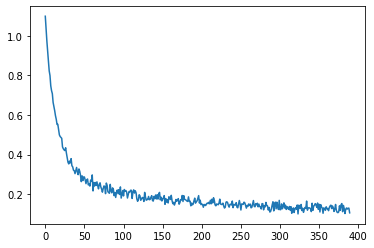

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

## 2.5 The Reverse Step

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that looks like a real image:

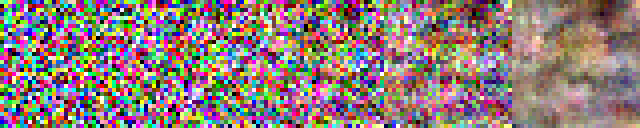

In [ ]:
def p_xt(xt, noise, t):
  alpha_t = gather(alpha, t)
  alpha_bar_t = gather(alpha_bar, t)
  eps_coef = (1 - alpha_t) / (1 - alpha_bar_t) ** .5
  mean = 1 / (alpha_t ** 0.5) * (xt - eps_coef * noise)
  var = gather(beta, t)
  eps = torch.randn(xt.shape, device=xt.device)
  return mean + (var ** 0.5) * eps

x = torch.randn(1, 3, 32, 32).cuda() # Start with random noise
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))
    if i%24 == 0:
      ims.append(tensor_to_image(x.cpu()))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims[:5]):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

We're only training here with 100 noise steps, and perhaps the model mostly sees images with at least a little bit of structure to them. If we start with a half-noised image can it at least 'fix' it back to something like the original?

torch.Size([10, 3, 32, 32])


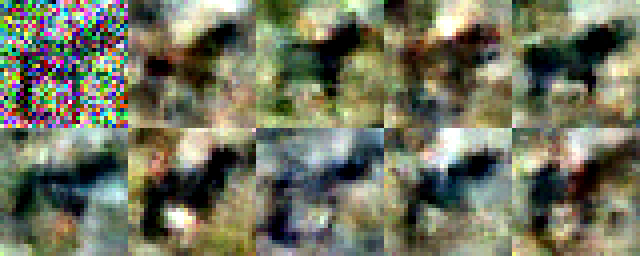

In [ ]:
#@title Start with a heavily noised horse (t=50, top left = starting point):
horse = cifar10['train'][4]['img']
x0 = img_to_tensor(horse)
x = torch.cat([q_xt_x0(x0.cuda(), torch.tensor(50, dtype=torch.long).cuda())[0] for _ in range(10)] )
example_start = q_xt_x0(x0.cuda(), torch.tensor(50, dtype=torch.long).cuda())[0]
print(x.shape)
ims = []
for i in range(10, n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))

for i in range(10):
  ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))

image = Image.new('RGB', size=(32*5, 32*2))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 32*(i//5)))
  if i==0:image.paste(tensor_to_image(example_start.unsqueeze(0).cpu()), ((i%5)*32, 32*(i//5))) # Show the heavily noised starting point top left
image.resize((32*4*5, 32*4*2), Image.NEAREST)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In the DDPM paper (https://arxiv.org/abs/2006.11239) they train their CIFAR10 model on a TPU v3-8 (similar to 8 V100 GPUs) at 21
steps per second at batch size 128 (10.6 hours to train to completion at 800k steps). So a little more training than our example above!

Sampling a batch of 256 images takes 17 seconds. They also use dropout (rate 0.1) to try to combat overfitting. LR is 2e-4. They use 1000 steps for everything. Later papers use as many as 4000 steps, with a slight resultant increase in quality. Their model is something like 37 million parameters.

# Compression using standard image compression algorithms

*Image* compression of the resultant denoised image


[[2.54296875 1.06542969]
 [2.52050781 1.06152344]
 [2.5234375  1.0859375 ]
 [2.54785156 1.08398438]
 [2.54003906 1.07910156]
 [2.48632812 1.0390625 ]
 [2.55273438 1.09667969]
 [2.49804688 1.05078125]
 [2.53222656 1.05957031]
 [2.56054688 1.07324219]]


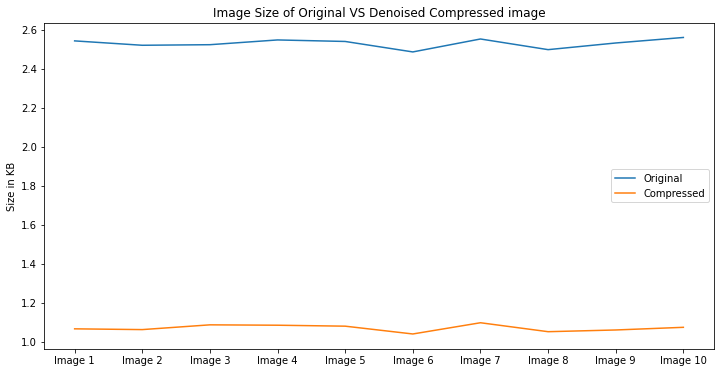

In [ ]:
import PIL
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

denoised = []
compressed = []
denoised_size = []
compressed_size = []

for im in ims:
  denoised.append(im)
  denoised[-1].save('denoised.png')
  denoised_size.append(os.stat('denoised.png').st_size / 1024)

  denoised[-1].save('compressed.jpg', 'JPEG', quality=95, optimize=True)
  compressed.append(Image.open('compressed.jpg'))
  compressed_size.append(os.stat('compressed.jpg').st_size / 1024)

print(np.array(list(zip(denoised_size, compressed_size))))
fig = plt.figure(figsize=(12, 6))
plt.plot(list(range(len(ims))), denoised_size, color='tab:blue', label='Original')
plt.plot(list(range(len(ims))), compressed_size, color='tab:orange', label='Compressed')
plt.ylabel('Size in KB')
plt.xticks(list(range(len(ims))), ['Image {0}'.format(i+1) for i in range(len(ims))])
plt.title('Image Size of Original VS Denoised Compressed image')
plt.legend()
plt.show()

Comparizon of Denoised and compressed images with respeect to PSNR and SNR

In [ ]:
def plot_cmp(t, data, title, x_label, y_label, x_labels, legend_list):
    rect_list = []

    def width_adjust(a_width):
        optimized_width = a_width * len(data[0])

        count = len(str(a_width)) - 2
        adjustment = '0.'
        while count > 0:
            adjustment += '0'
            count -= 1
        adjustment += '1'
        adjustment = float(adjustment)
        while optimized_width + gap * len(data[0]) >= 0.95:
            a_width -= adjustment
            optimized_width = a_width * len(data[0])
        return a_width

    def group_chart():
        cmap = plt.get_cmap('tab20')
        for i in range(len(data)):
            x = - ((len(data[0]) - 1) * (width + gap) / 2) + i
            for j in range(len(data[0])):
                rect_list.append(ax.bar(x, data[i][j], width, color=cmap.colors[j]))
                x += width + gap

    def legend():
        rect_li = [rec[0] for rec in rect_list]
        ax.legend(rect_li, legend_list, loc='best')

    ind = np.arange(len(data))
    width = 0.8
    gap = 0.0

    fig = plt.figure(figsize=(14, 8))
    ax = fig.gca()
    width = width_adjust(width)
    group_chart()

    ax.set_ylim([0, 40])
    ax.set_xlabel(x_label, labelpad=10)
    ax.set_ylabel(y_label, labelpad=10)
    ax.set_xticks(ind)
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels([int(v) for v in ax.get_yticks()])
    legend()
    ax.set_title(title, pad=12)
    plt.show()

[[32.60492936  1.91940047  1.93344831]
 [32.36691764  1.74522839  1.75676943]
 [32.21389095  1.79438878  1.81022217]
 [32.54385069  1.68503399  1.69143714]
 [32.46612946  1.66860066  1.67774379]
 [32.7203606   1.80727062  1.81519847]
 [32.30896367  1.49225995  1.50564528]
 [32.65059826  2.15737062  2.16585921]
 [32.45819588  1.90513114  1.91607772]
 [32.28141368  1.71195389  1.72163369]]


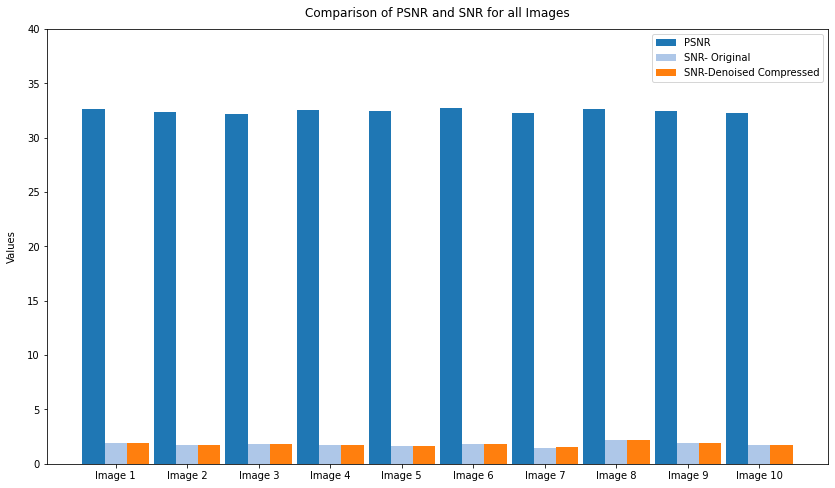

In [ ]:
def mean_squared_error(i1, i2):
  return np.mean((i1 - i2) ** 2)


def psnr(mse):
  if mse > 0:
    return 20 * math.log10(255.0 / math.sqrt(mse))
  return float(100)


def snr(i):
    mean = np.mean(i)
    std = np.std(i)
    if std > 0:
      return mean / std
    return 0


psnr_ = []
denoised_snr = []
compressed_snr = []
for i in range(len(ims)):
  denoised_arr = np.asarray(denoised[i])
  compressed_arr = np.asarray(compressed[i])
  psnr_.append(psnr(mean_squared_error(denoised_arr, compressed_arr)))
  denoised_snr.append(snr(denoised_arr))
  compressed_snr.append(snr(compressed_arr))

data = np.array(list(zip(psnr_, denoised_snr, compressed_snr))).T
print(data.T)
plot_cmp(
    t,
    data=data.T, title='Comparison of PSNR and SNR for all Images',
    x_label='', y_label='Values',
    x_labels=['Image {0}'.format(i+1) for i in range(len(ims))],
    legend_list=['PSNR', 'SNR- Denoised', 'SNR- Compressed'],
)

Comparision of denoised and compressed image

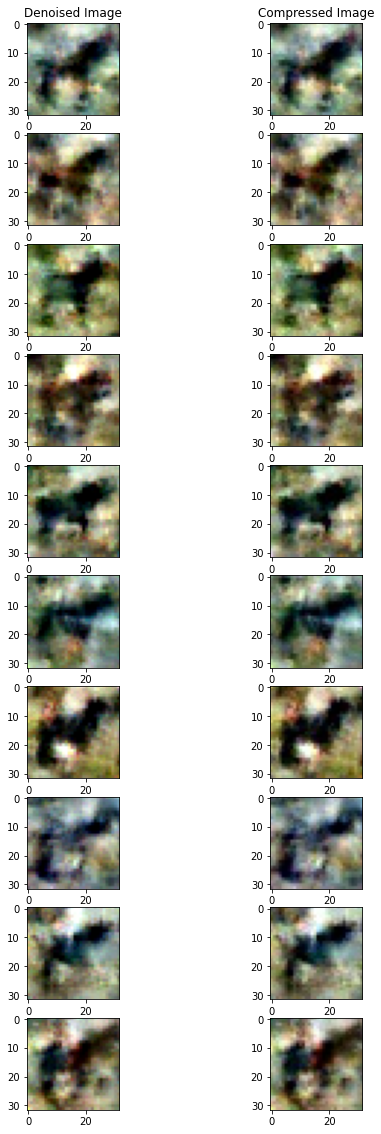

In [ ]:
fig, axes = plt.subplots(len(ims), 2, figsize=(8, 20))
for i in range(len(ims)):
  axes[i][0].imshow(denoised[i])
  if i == 0:
    axes[i][0].set_title('Denoised Image')
    axes[i][1].set_title('Compressed Image')
  axes[i][1].imshow(compressed[i])
plt.show()